Load Model and Tokenizer

In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from src.etoken import ETokenizer 

device = "cpu"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)

# Load tokenizer 
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_5268/999024866.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location

number of parameters: 10.66M


Initialize Vocabulary Manager

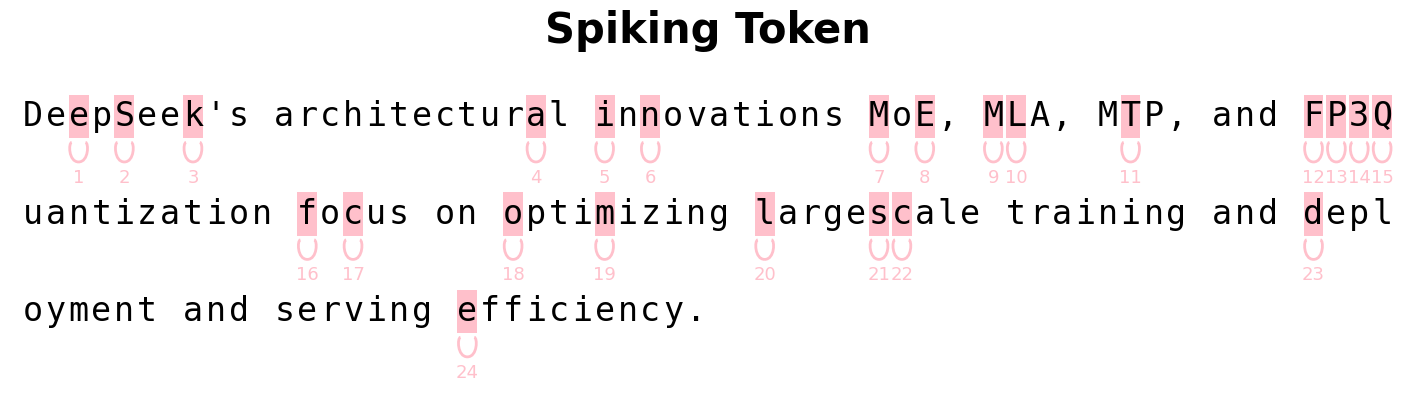

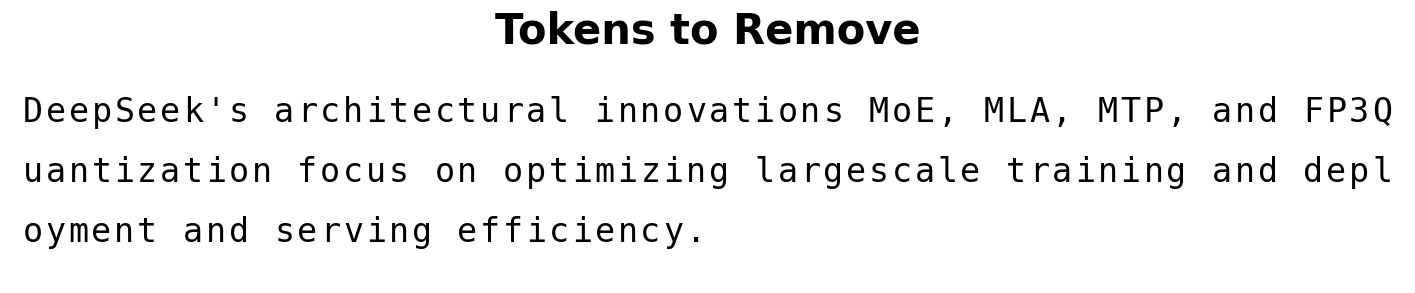

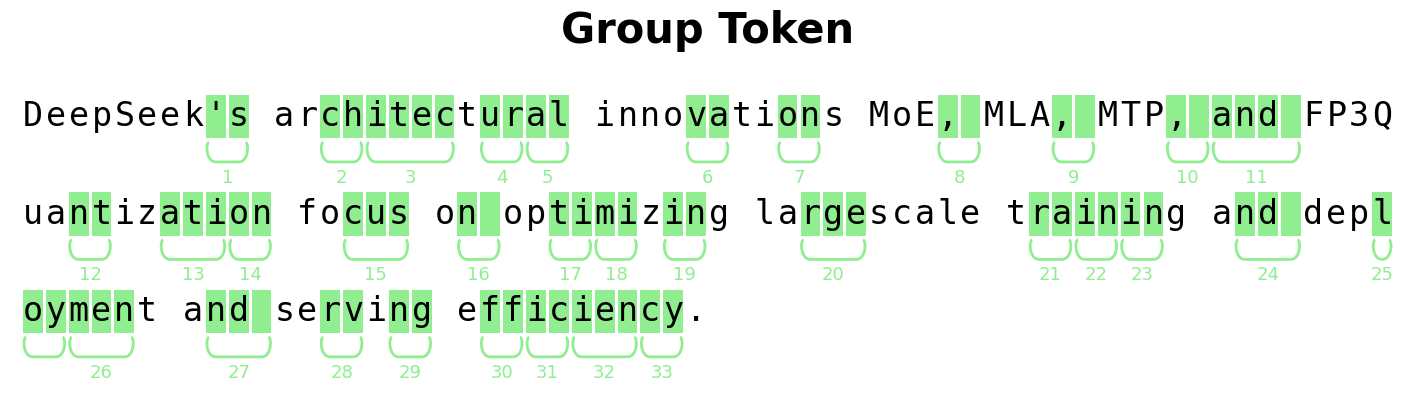

In [2]:
# Initialize Vocabulary Manager 
from src import Magicab
magicab = Magicab(model, tok)

text = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
magicab.visualize_changes(text)

In [3]:
magicab
